In [1]:
# Paso 0: Importar librerias necesarias

import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import pylab as plt
from pandas.plotting import lag_plot


In [2]:
# Paso 1: Importar el DF de todas las empresas del IBEX 35

df = pd.read_csv('ibex35.csv')

df.head()

,id,ticker,empresa,date,open,high,low,close,adj close,volume
0,1,ANA,Acciona,2019-01-02,73.900002,73.900002,73.900002,73.900002,64.148270,0
1,1,ANA,Acciona,2022-06-24,174.199997,178.800003,174.000000,178.800003,169.562302,0
2,1,ANA,Acciona,2022-06-23,169.899994,173.199997,169.000000,173.000000,164.061951,0
3,1,ANA,Acciona,2022-06-22,171.399994,171.399994,168.800003,170.199997,161.406616,0
4,1,ANA,Acciona,2022-06-21,179.699997,179.699997,172.300003,173.600006,164.630966,0


In [3]:
# Paso 2: Filtrar por la empresa sobre la que realizar el modelo

melia = df[df['empresa'] == 'Melia']

melia.shape

(939, 10)

In [4]:
# Paso 3: Seleccionar las columnas definitivas que utilizaremos

melia = melia [['date','open','high','low','close','adj close']]

melia.shape

(939, 6)

In [5]:
# Paso 4: Modificar el formato de columna 'date' (format: object ===> datatime)

melia['date'] = pd.to_datetime(melia['date'], format="%Y-%m-%d")

melia.info()

<class 'pandas.core.frame.DataFrame'>
Index: 939 entries, 31150 to 32088
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       939 non-null    datetime64[ns]
 1   open       939 non-null    float64       
 2   high       939 non-null    float64       
 3   low        939 non-null    float64       
 4   close      939 non-null    float64       
 5   adj close  939 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 51.4 KB


In [6]:
# Paso 5: Ordenar el DF por fecha

melia.sort_values(by='date',ascending= True, inplace=True)

melia.head()

,date,open,high,low,close,adj close
31768,2020-07-02,3.684,4.082,3.684,4.000,4.000
31769,2020-07-03,4.010,4.010,3.908,3.952,3.952
31770,2020-07-06,4.000,4.110,4.000,4.084,4.084
31771,2020-07-07,3.988,3.988,3.888,3.888,3.888
31772,2020-07-08,3.828,3.828,3.796,3.818,3.818


In [7]:
# Paso 6: Filtrar nuevamente para eliminar efecto COVID del análisis (previo a 2021)

# Filtro:

fecha_inicio = '2021-01-01'
fecha_fin = '2024-03-01'

melia = melia[(melia['date'] >= fecha_inicio) & (melia['date'] <= fecha_fin)]

# Comprobar si se ha aplicado correctamente

melia.shape

(811, 6)

In [8]:
# Paso 7: Añadir al DF fechas obviadas por mercado de valores español (fin de semana y festivos)

# Rango de fechas desde '2021-01-01' a '2024-03-01'

date_range = pd.date_range(start=melia['date'].min(), end=melia['date'].max(), freq='D')

# Reindexa el DF con el nuevo rango de fechas

melia = melia.set_index('date').reindex(date_range).reset_index()

# Volver a modificar el nombre de columna 'date'

melia = melia.rename(columns={'index': 'date'})


In [9]:
# Paso 8: Comprobar que ha introducido la fechas ausentes en el DF original

melia.head(10)

,date,open,high,low,close,adj close
0,2021-01-04,5.645,5.710,5.295,5.340,5.340
1,2021-01-05,5.365,5.415,5.210,5.325,5.325
2,2021-01-06,5.345,5.590,5.340,5.560,5.560
3,2021-01-07,5.565,5.565,5.475,5.490,5.490
4,2021-01-08,5.520,5.675,5.515,5.575,5.575
5,2021-01-09,NaN,NaN,NaN,NaN,NaN
6,2021-01-10,NaN,NaN,NaN,NaN,NaN
7,2021-01-11,5.580,5.580,5.420,5.455,5.455
8,2021-01-12,5.450,5.700,5.450,5.650,5.650
9,2021-01-13,5.675,5.675,5.555,5.605,5.605


In [10]:
# Paso 9: Rellenar valores nulos con el anterior valor de la columna(viernes o previo a festivo)

melia = melia.fillna(method='ffill')

In [11]:
# Paso 10: Comprobar que se han introducido los valores correctamente


melia.head(10)

,date,open,high,low,close,adj close
0,2021-01-04,5.645,5.710,5.295,5.340,5.340
1,2021-01-05,5.365,5.415,5.210,5.325,5.325
2,2021-01-06,5.345,5.590,5.340,5.560,5.560
3,2021-01-07,5.565,5.565,5.475,5.490,5.490
4,2021-01-08,5.520,5.675,5.515,5.575,5.575
5,2021-01-09,5.520,5.675,5.515,5.575,5.575
6,2021-01-10,5.520,5.675,5.515,5.575,5.575
7,2021-01-11,5.580,5.580,5.420,5.455,5.455
8,2021-01-12,5.450,5.700,5.450,5.650,5.650
9,2021-01-13,5.675,5.675,5.555,5.605,5.605


In [12]:
# Paso 11: Establecer columna 'date' como índice para modelo

melia = melia.set_index('date')

melia.head(10)

,open,high,low,close,adj close
date,,,,,
2021-01-04,5.645,5.710,5.295,5.340,5.340
2021-01-05,5.365,5.415,5.210,5.325,5.325
2021-01-06,5.345,5.590,5.340,5.560,5.560
2021-01-07,5.565,5.565,5.475,5.490,5.490
2021-01-08,5.520,5.675,5.515,5.575,5.575
2021-01-09,5.520,5.675,5.515,5.575,5.575
2021-01-10,5.520,5.675,5.515,5.575,5.575
2021-01-11,5.580,5.580,5.420,5.455,5.455
2021-01-12,5.450,5.700,5.450,5.650,5.650


In [13]:
# Paso 12: Establecer siguiente criterio para que el modelo AR funcione

melia.index = pd.DatetimeIndex(melia.index).to_period('d')

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

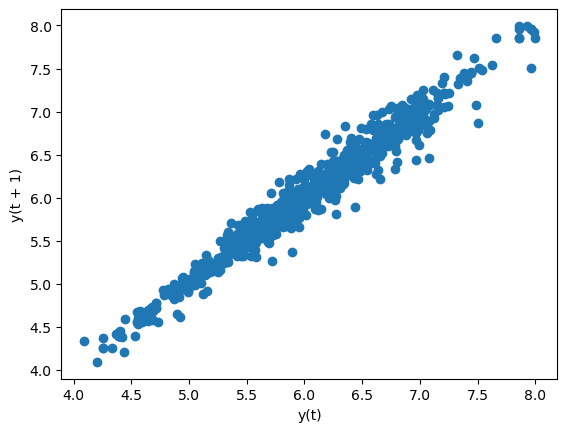

In [14]:
# Paso 13: Comprobar linealidad de la variable y = 'close'

lag_plot(melia.close)

In [15]:
# Paso 14: Importar modelo de AR

from statsmodels.tsa.ar_model import AutoReg as AR

In [16]:
# Paso 15: Realizar el split en el DF del train y el test

train, test = melia.close[:-10], melia.close[-10:]

train.shape, test.shape

((1143,), (10,))

In [17]:
# Paso 16: Entrenar el modelo de AR

modelo = AR(train, lags=1).fit()

In [18]:
# Paso 17: Realizar predicción con el entrenamiento

pred = modelo.predict(len(train), len(melia.close)-1)

# Check sobre los valores de la predicción

pred

2024-02-21    6.730779
2024-02-22    6.721699
2024-02-23    6.712757
2024-02-24    6.703951
2024-02-25    6.695280
2024-02-26    6.686740
2024-02-27    6.678331
2024-02-28    6.670050
2024-02-29    6.661895
2024-03-01    6.653864
Freq: D, dtype: float64

In [19]:
# Paso 18: Chequear coincidencia entre test y pred

test

date
2024-02-21    6.800
2024-02-22    6.825
2024-02-23    6.875
2024-02-24    6.875
2024-02-25    6.875
2024-02-26    6.930
2024-02-27    6.770
2024-02-28    6.690
2024-02-29    6.745
2024-03-01    6.630
Freq: D, Name: close, dtype: float64

In [20]:
# Paso 19: Calcular el error de la predicción sobre la realidad

error = (pred - test).abs().sum()/len(pred)  

error

0.11473825781170799

In [21]:
# Paso 20: Generar un DF sobre la comparativa en realidad, predicción y error

res=pd.DataFrame({'real': test, 'pred': pred, 'error': pred - test})

res

,real,pred,error
2024-02-21,6.800,6.730779,-0.069221
2024-02-22,6.825,6.721699,-0.103301
2024-02-23,6.875,6.712757,-0.162243
2024-02-24,6.875,6.703951,-0.171049
2024-02-25,6.875,6.695280,-0.179720
2024-02-26,6.930,6.686740,-0.243260
2024-02-27,6.770,6.678331,-0.091669
2024-02-28,6.690,6.670050,-0.019950
2024-02-29,6.745,6.661895,-0.083105
2024-03-01,6.630,6.653864,0.023864
